In [58]:
# Load libs
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [59]:
# dataset downloading, selecting and reordering columns for further analysis
dataset=pd.read_excel("cata.xlsx")
dataset=dataset.drop(['name','sibsp', 'parch', 'ticket', 'fare', 
                      'cabin', 'embarked', 'boat', 'body', 'home.dest'],axis=1)
dataset=dataset[['survived','pclass', 'sex', 'age']]

# checking the dataset for nan and deleting empty rows
dataset.isna().sum()
dataset=dataset.dropna(axis=0)

# formatting the "survived" column into categorical
dataset.survived.replace(to_replace=[0,1],value=["no","yes"], inplace=True)
dataset.sex.replace(to_replace=["female","male"],value=[0,1], inplace=True)
dataset = dataset.astype({'survived':'category','pclass':'int','sex':'int','age':'float'})

# split-out validation dataset
array = dataset.values
X = array[:,1:]
y = array[:,0]

# set up the train & test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# standardize the dataset manually (except for the categorical values)
m=np.mean(X_train[:,2])
s=np.std(X_train[:,2])
X_train[:,2]=(X_train[:,2]-m)/s
X_test[:,2]=(X_test[:,2]-m)/s


# the goal is to check different models for prediction (linear and non-linear ones)
# individually and then deploy different options of the Ensemble Learning and Decision Trees
# the list of the individual models is given below:
# Logistic Regression (LR)
# Linear Discriminant Analysis (LDA)
# K-Nearest Neighbors (KNN)
# Gaussian Naive Bayes (NB)
# Classification Trees (CART)

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier()))

In [60]:
# below is a set of different models for prediction (linear and non-linear ones)
# and the result of predictions for the validation (test) dataset
# max accuracy score - 0.8 for individual models
results = []
names = []
for name, model in models:
    model.fit(X_train, Y_train)
    predictions=model.predict(X_test)
    print('model name - %.5s, accuracy score - %.2f' % 
        (name,accuracy_score(Y_test,predictions)))

model name - LR, accuracy score - 0.80
model name - LDA, accuracy score - 0.80
model name - KNN, accuracy score - 0.79
model name - NB, accuracy score - 0.80
model name - CART, accuracy score - 0.79


In [61]:
# further I'll experiment with different algorythms of the Ensemble Learning and Decision Trees
# to maximize the accuracy of the predictions
# 1/ I'm going to start with the Voting Classifier which gives the accuracy score 0.8
vc=VotingClassifier(estimators=models)
vc.fit(X_train, Y_train)
predictions=vc.predict(X_test)
vc_as=round(accuracy_score(Y_test,predictions),2)
name='VotingClassifier accuracy score - '
results.append((name,vc_as))
print(name,vc_as)

VotingClassifier accuracy score -  0.8


In [62]:
# 2/ I'll use bagging technique - Bootstrap Aggregation to reduce variance of idividual models in the ensemble
# n_estimators is set to 300 classification trees
# BaggingClassifier also shows the accuracy score 0.8
dt=DecisionTreeClassifier()
bc=BaggingClassifier(estimator=dt,n_estimators=300,n_jobs=-1)
bc.fit(X_train, Y_train)
predictions=vc.predict(X_test)
bc_as=round(accuracy_score(Y_test,predictions),2)
name='BaggingClassifier accuracy score - '
results.append((name,bc_as))
print(name,bc_as)

BaggingClassifier accuracy score -  0.8


In [63]:
# the problem with Bagging is that some instances may not be sampled at all
# for this time I'm going to retrieve the Out of Bag (OOB) instances, the accuracy score of OBB is 0.78
bc=BaggingClassifier(estimator=dt,n_estimators=300,oob_score=True,n_jobs=-1)
bc.fit(X_train, Y_train)
predictions=vc.predict(X_test)
bc_as=round(accuracy_score(Y_test,predictions),2)
oob_as=round(bc.oob_score_,2)
print('BaggingClassifier accuracy score - ',bc_as)
print('BaggingClassifier OOB accuracy score - ',oob_as)

BaggingClassifier accuracy score -  0.8
BaggingClassifier OOB accuracy score -  0.78


In [64]:
# 3/ I'll deploy the Random Forests to further randomize the training of individual trees
# RandomForestClassifier shows the accuracy score 0.82 
rfc=RandomForestClassifier(n_estimators=400,min_samples_leaf=0.17,random_state=1)
rfc.fit(X_train, Y_train)
predictions=rfc.predict(X_test)
rfc_as=round(accuracy_score(Y_test,predictions),2)
name='RandomForestClassifier accuracy score - '
results.append((name,rfc_as))
print(name,rfc_as)

RandomForestClassifier accuracy score -  0.82


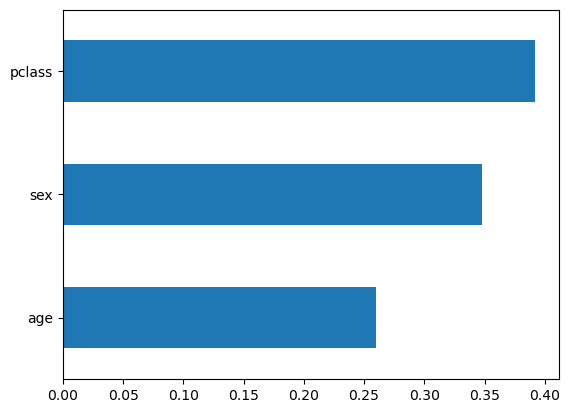

In [65]:
# let's analyze further the feature importance for the RandomForestClassifier 
# surprisingly the class of passengers (pclass) is more important vs sex 
importances_rfc=pd.Series(rfc.feature_importances_,index=['pclass', 'sex', 'age'])
importances_rfc=importances_rfc.sort_values()
importances_rfc.plot(kind='barh')
plt.show()

In [66]:
# 4/ further I'll deploy boosting - the ensemble method combining several weak learners to form a strong learner
# each predictor pays more attention to the instances wrongly predicted by its predecessor
# and I start from the Adaptive Boosting (Adaboost) which gives the accuracy score 0.78
abc=AdaBoostClassifier(estimator=dt,n_estimators=100)
abc.fit(X_train, Y_train)
predictions=abc.predict(X_test)
abc_as=round(accuracy_score(Y_test,predictions),2)
name='AdaBoostClassifier accuracy score - '
results.append((name,abc_as))
print(name,abc_as)

AdaBoostClassifier accuracy score -  0.78


In [67]:
# then I'll exiperiment with the Gradient Boosted Trees which improves the accuracy to 0.82
gbc=GradientBoostingClassifier(n_estimators=300,max_depth=1,random_state=1)
gbc.fit(X_train, Y_train)
predictions=gbc.predict(X_test)
gbc_as=round(accuracy_score(Y_test,predictions),2)
name='GradientBoostingClassifier accuracy score - '
results.append((name,gbc_as))
print(name,gbc_as)

GradientBoostingClassifier accuracy score -  0.82


In [68]:
# this time i'll deploy the Stochastic Gradient Boosting method to maximize the accuracy
# each tree to sample 80% of the data for training
# and each tree to use 20% of available features to perform the best split
# SGBC gives the accuracy score 0.82
sgbc=GradientBoostingClassifier(n_estimators=300,max_depth=1,random_state=1,subsample=0.8,max_features=0.2)
sgbc.fit(X_train, Y_train)
predictions=sgbc.predict(X_test)
sgbc_as=round(accuracy_score(Y_test,predictions),2)
name='Stochastic GradientBoostingClassifier accuracy score - '
results.append((name,sgbc_as))
print(name,sgbc_as)

Stochastic GradientBoostingClassifier accuracy score -  0.82


In [69]:
# and finally to check whether the ensemble learning gave a good accuracy score 
# vs Hyperparameter Tuning I'll run GridSearchCV for DecisionTreeClassifier to compare the scores
param_grid = {'max_depth': [1,2,3,4,5,6], 
              'min_samples_leaf': [0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18],
              'max_features': [0.2,0.4,0.6,0.8,1]} 
grid = GridSearchCV(estimator=dt,param_grid=param_grid,scoring='accuracy',cv=10,n_jobs=-1)
grid.fit(X_train, Y_train)
print('grid.best_params_: ',grid.best_params_)

grid.best_params_:  {'max_depth': 6, 'max_features': 0.8, 'min_samples_leaf': 0.06}


In [70]:
grid_as=round(grid.best_score_,2)
print('GridSearchCV DecisionTreeClassifier accuracy score for the train set - ',grid_as)

GridSearchCV DecisionTreeClassifier accuracy score for the train set -  0.78


In [71]:
# Hyperparameter Tuning for DecisionTreeClassifier gives the accuracy score 0.81
best_model=grid.best_estimator_
test_acc=round(best_model.score(X_test,Y_test),2)
name='GridSearchCV DecisionTreeClassifier accuracy score for the test set - '
results.append((name,test_acc))
print(name,test_acc)

GridSearchCV DecisionTreeClassifier accuracy score for the test set -  0.81


In [72]:
# to summarize the results of the experiment:
# I deployed different variations of ensemble learning algorythms (VotingClassifer, BaggingClassifier)
# also used RandomForestClassifier (for the accuracy score and features selection)
# then I utilized different option of boosters: AdaBoostClassifier, GradientBoostingClassifier, Stochastic GradientBoostingClassifier
# and finally I launched GridSearchCV for Hyperparameter Tuning for DecisionTreeClassifier to compare the scores
# the best accuracy score (0.82): RandomForestClassifier,Stochastic and GradientBoostingClassifier
results

[('VotingClassifier accuracy score - ', 0.8),
 ('BaggingClassifier accuracy score - ', 0.8),
 ('RandomForestClassifier accuracy score - ', 0.82),
 ('AdaBoostClassifier accuracy score - ', 0.78),
 ('GradientBoostingClassifier accuracy score - ', 0.82),
 ('Stochastic GradientBoostingClassifier accuracy score - ', 0.82),
 ('GridSearchCV DecisionTreeClassifier accuracy score for the test set - ',
  0.81)]